
# Practical 7: Convolutions, Pooling & AlexNet (From First Principles to a Flower Classifier)

**What you'll learn today**
- ✅ What a **convolutional layer** does and why it is the core of CNNs  
- ✅ How to **implement convolution & pooling** and understand their effects  
- ✅ Why **AlexNet (2012)** was a *breakthrough* that changed the field  
- ✅ The **architecture** of AlexNet, layer by layer  
- ✅ How to **use AlexNet (PyTorch)** with pretrained ImageNet weights to classify flowers  
- ✅ See an **AlexNet structure** in TensorFlow/Keras (note: no official pretrained ImageNet weights there)

> **Dataset:** Please download the prepared **flowers** dataset from my Google Drive.  
> The folder contains three subfolders: `train/`, `val/`, `test/`. Each has **five class folders**.  
> This dataset is **slightly different** from the previous flowers dataset we used — make sure to use this one.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## 1) What does a Convolutional Layer do?

A **convolution** slides a small window (called a **kernel** or **filter**) over the image.  
At each location it computes a **weighted sum** of the pixels underneath. The weights are the filter values.

- If a filter looks like an **edge detector**, then its output (called a **feature map**) will be high on edges.
- In a CNN, these filters are **learned** automatically from data, so the network discovers useful patterns.

**Vocabulary cheat sheet**
- **Stride:** how far the filter jumps each step (e.g., stride=2 moves two pixels at a time).
- **Padding:** how we handle borders; "same" padding keeps output size similar by adding zeros around the image.
- **Channels:** color images have 3 channels (RGB). A conv filter typically spans *all* input channels.


In [1]:

# Tiny 2D convolution demo (NumPy only) to make the idea concrete
import numpy as np

# A tiny 6x6 grayscale "image" with a bright region in the center
img = np.array([
    [10,10,10,10,10,10],
    [10,50,50,50,50,10],
    [10,50,90,90,50,10],
    [10,50,90,90,50,10],
    [10,50,50,50,50,10],
    [10,10,10,10,10,10]
], dtype=np.float32)

# A simple horizontal edge detector (Sobel-like). Positive values on the bottom row,
# negative on the top row -> it responds strongly where intensity changes vertically.
kernel = np.array([
    [-1,-2,-1],
    [ 0, 0, 0],
    [ 1, 2, 1]
], dtype=np.float32)

def conv2d_same(x, k):
    """A minimal 'same' 2D convolution for teaching.
    - Pads the image with zeros so output has same HxW as input
    - Slides the kernel and computes sum(patch * kernel)
    """
    H, W = x.shape
    kh, kw = k.shape
    pad_h, pad_w = kh//2, kw//2

    # Zero padding adds a border so the kernel can be centered at edges
    xp = np.pad(x, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    out = np.zeros_like(x)

    # Slide kernel over every (i,j) location
    for i in range(H):
        for j in range(W):
            patch = xp[i:i+kh, j:j+kw]
            out[i,j] = np.sum(patch * k)
    return out

edge_map = conv2d_same(img, kernel)
print("Input:\n", img)
print("\nEdge response (big numbers near edges):\n", edge_map)


Input:
 [[10. 10. 10. 10. 10. 10.]
 [10. 50. 50. 50. 50. 10.]
 [10. 50. 90. 90. 50. 10.]
 [10. 50. 90. 90. 50. 10.]
 [10. 50. 50. 50. 50. 10.]
 [10. 10. 10. 10. 10. 10.]]

Edge response (big numbers near edges):
 [[  70.  160.  200.  200.  160.   70.]
 [  40.  160.  280.  280.  160.   40.]
 [   0.   40.  120.  120.   40.    0.]
 [   0.  -40. -120. -120.  -40.    0.]
 [ -40. -160. -280. -280. -160.  -40.]
 [ -70. -160. -200. -200. -160.  -70.]]



### 2) Pooling in one minute

**Pooling** reduces the spatial size of feature maps. The most common is **MaxPooling**:
- splits the feature map into small regions (e.g., 2×2),
- takes the **maximum** value from each region,
- outputs a **smaller** map (fewer numbers) that keeps the strongest signal.

**Why it helps**
- **Computation:** smaller maps → faster later layers
- **Robustness:** small translations/noise won't change the maximum much
- **Focus:** it keeps the strongest evidence for a feature



## 3) A real image convolution (quick visual)
We'll convolve a grayscale coffee image with a simple edge filter to see edges pop out.


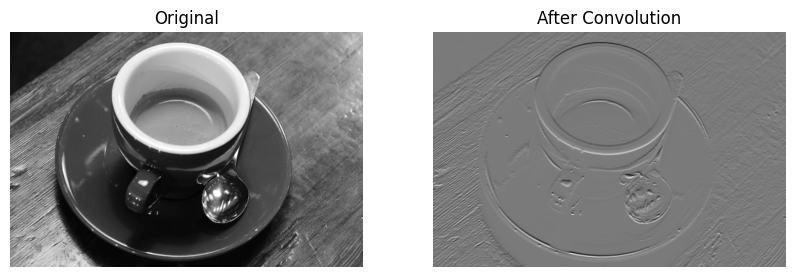

In [2]:

# If scikit-image is missing in your environment, uncomment the install line:
# !pip install -q scikit-image scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import data, color

# Convert sample image to grayscale float in [0,1]
image = color.rgb2gray(data.coffee())

# A vertical edge detector (top row negative, bottom row positive)
# You can change the filter to see different output
filt = np.array([[-1,-1,-1],
                 [ 0, 0, 0],
                 [ 1, 1, 1]], dtype=np.float32)

conv = convolve2d(image, filt, mode='same', boundary='symm')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(image, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title("After Convolution"); plt.imshow(conv, cmap='gray'); plt.axis('off')
plt.show()



## 4) AlexNet: Why it was a *Breakthrough* (2012)

Before 2012, classic computer vision approaches (SIFT, HOG, shallow classifiers) dominated.  
**AlexNet** changed that by **winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC)** by a **huge margin**.

**What made AlexNet special?**
1. **Deep Convolutional Network** (8 learned layers): showed depth really matters on large datasets.  
2. **ReLU activations** instead of sigmoid/tanh → much **faster training** and less vanishing gradient.  
3. **GPU training** at scale (actually used **two GPUs** in parallel) → made big models practical.  
4. **Data augmentation** (random crops, flips) → more effective data for free.  
5. **Dropout** in fully-connected layers → strong regularization, reduced overfitting.  
6. **Local Response Normalization (LRN)** (historical) → today usually replaced by BatchNorm or omitted.

**Impact:** AlexNet kicked off the modern deep learning wave in vision. Most CNNs you know today (VGG, ResNet, etc.) build on these ideas.



### 4.1 AlexNet architecture (modern PyTorch-style, input 224×224)

- **Conv1:** 64 filters, **11×11**, stride **4**, padding **2** → ReLU → **MaxPool 3×3 (stride 2)**  
  *Large receptive field early on reduces spatial size and captures broad edges/blobs.*

- **Conv2:** 192 filters, **5×5**, padding **2** → ReLU → **MaxPool 3×3 (stride 2)**  
  *Builds richer mid-level patterns.*

- **Conv3:** 384 filters, **3×3**, padding **1** → ReLU  
- **Conv4:** 256 filters, **3×3**, padding **1** → ReLU  
- **Conv5:** 256 filters, **3×3**, padding **1** → ReLU → **MaxPool 3×3 (stride 2)**  
  *Stacks of 3×3 learn complex textures, corners, and parts.*

- **Classifier:** Flatten → **FC 4096** → Dropout(0.5) → **FC 4096** → Dropout(0.5) → **FC num_classes**  
  *High-capacity classifier converts features to class scores.*



## 5) AlexNet in TensorFlow/Keras (structure demo)

> ⚠️ **Note:** There are **no official pretrained ImageNet weights** for AlexNet in TensorFlow/Keras.  
> We'll define the model **for learning the architecture**, but we won't train it here.


In [3]:

# AlexNet in TensorFlow/Keras: focused on layer structure (untrained)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def alexnet_tf(num_classes=5, input_shape=(224,224,3)):
    # We use Sequential for readability; each Conv is followed by ReLU and occasional MaxPool
    return keras.Sequential([
        # ----- Feature extractor -----
        layers.Conv2D(64, 11, strides=4, padding='same', input_shape=input_shape),
        layers.ReLU(),
        layers.MaxPool2D(pool_size=3, strides=2),

        layers.Conv2D(192, 5, padding='same'),
        layers.ReLU(),
        layers.MaxPool2D(pool_size=3, strides=2),

        layers.Conv2D(384, 3, padding='same'), layers.ReLU(),
        layers.Conv2D(256, 3, padding='same'), layers.ReLU(),
        layers.Conv2D(256, 3, padding='same'), layers.ReLU(),
        layers.MaxPool2D(pool_size=3, strides=2),

        # ----- Classifier -----
        layers.Flatten(),
        layers.Dense(4096), layers.ReLU(), layers.Dropout(0.5),
        layers.Dense(4096), layers.ReLU(), layers.Dropout(0.5),
        layers.Dense(num_classes)  # logits (use from_logits=True in loss)
    ], name='alexnet_tf')

model_tf = alexnet_tf()
model_tf.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "alexnet_tf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 192)    │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 27, 27, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,024,325 (217.53 MB)

 Trainable params: 57,024,325 (217.53 MB)

 Non-trainable params: 0 (0.00 B)


## 6) AlexNet in PyTorch (with pretrained weights) — Flower Classification

**Why PyTorch here?** TorchVision provides **pretrained ImageNet** weights for AlexNet, which makes fine‑tuning effective even with a modest dataset.

### 6.1 Prepare the dataset
1. Download the **flowers dataset** from my Google Drive: [Flowers Dataset Link](https://drive.google.com/file/d/1Oaghg3cBXOD88LAfa5pWXzuHtiJ93o7O/view?usp=sharing)
2. Put it somewhere on your machine and set `DATA_DIR` below to that path.
3. The folder structure must be:
```
DATA_DIR/
  train/  <five class folders>
  val/    <five class folders>
  test/   <five class folders>
```

In [22]:

# ---- Install (if needed) and imports ----
# If your environment already has torch/torchvision, the install line will be ignored.
# Tip: remove the index-url if you're on CPU-only environment.
# !pip -q install torch torchvision torchaudio

import os, time, copy, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from typing import Dict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ---- Reproducibility ----
def set_seed(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# ====== 1) PATHS ======
DATA_DIR = "/content/drive/MyDrive/flowers"  # <-- TODO: change to your dataset root

# ====== 2) TRANSFORMS ======
# AlexNet expects 224x224 inputs normalized to ImageNet means/stds.
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),     # data augmentation: random crop & scale
    transforms.RandomHorizontalFlip(),          # augmentation: flip left/right
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

# ====== 3) DATASETS & LOADERS ======
# ImageFolder expects directories named by class; it assigns class indices automatically.
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=eval_tfms)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


Device: cuda
Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [6]:

# ---- Load pretrained AlexNet and adapt classifier ----
from torchvision.models import alexnet, AlexNet_Weights

# 1) Load ImageNet-pretrained weights (feature extractor already knows generic visual patterns)
weights = AlexNet_Weights.IMAGENET1K_V1
net = alexnet(weights=weights)

# 2) Option A: fine-tune all layers (good when you have a bit of data)
for p in net.parameters():
    p.requires_grad = True

# 3) Replace the final classification layer to predict our 5 flower classes
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, num_classes)

net = net.to(device)

# ---- Loss & Optimizer ----
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# Alternative: optimizer = optim.Adam(net.parameters(), lr=3e-4)


In [7]:

# ---- Training & Validation helpers ----
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, n = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # 1) Forward pass: compute logits
        logits = model(images)
        loss = criterion(logits, labels)

        # 2) Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 3) Bookkeeping
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        n += images.size(0)
    return running_loss/n, correct/n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, n = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        n += images.size(0)
    return running_loss/n, correct/n


In [10]:

# ---- Train the model and keep the best weights (by val accuracy) ----
best_wts = net.state_dict()
best_val_acc, history = 0.0, []
EPOCHS = 50  # Start small; you can increase later

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(net, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(net, val_loader, criterion)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_wts = copy.deepcopy(net.state_dict())

    history.append((epoch, tr_loss, tr_acc, val_loss, val_acc))
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} | "
          f"{time.time()-t0:.1f}s")

# Load the best performing parameters
net.load_state_dict(best_wts)


Epoch 01 | train loss 0.6257 acc 0.777 | val loss 0.4196 acc 0.836 | 741.4s
Epoch 02 | train loss 0.5117 acc 0.809 | val loss 0.3405 acc 0.882 | 36.4s
Epoch 03 | train loss 0.4682 acc 0.823 | val loss 0.2786 acc 0.892 | 36.9s
Epoch 04 | train loss 0.4004 acc 0.852 | val loss 0.2775 acc 0.904 | 35.7s
Epoch 05 | train loss 0.3862 acc 0.857 | val loss 0.2622 acc 0.906 | 36.1s
Epoch 06 | train loss 0.3646 acc 0.865 | val loss 0.2474 acc 0.918 | 35.2s
Epoch 07 | train loss 0.3363 acc 0.873 | val loss 0.2409 acc 0.908 | 36.4s
Epoch 08 | train loss 0.3294 acc 0.884 | val loss 0.2806 acc 0.896 | 36.4s
Epoch 09 | train loss 0.2982 acc 0.893 | val loss 0.2064 acc 0.926 | 36.6s
Epoch 10 | train loss 0.3153 acc 0.881 | val loss 0.1736 acc 0.940 | 38.2s
Epoch 11 | train loss 0.2657 acc 0.902 | val loss 0.1830 acc 0.940 | 34.8s
Epoch 12 | train loss 0.2639 acc 0.900 | val loss 0.1779 acc 0.944 | 36.0s
Epoch 13 | train loss 0.2746 acc 0.900 | val loss 0.1719 acc 0.950 | 35.8s
Epoch 14 | train loss 0.

<All keys matched successfully>

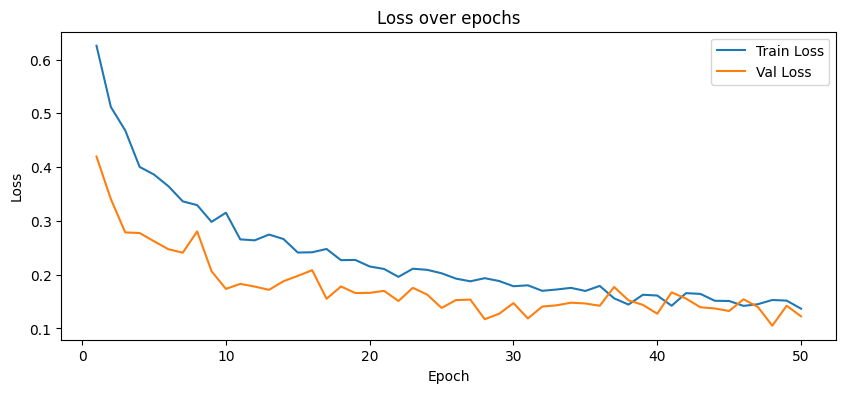

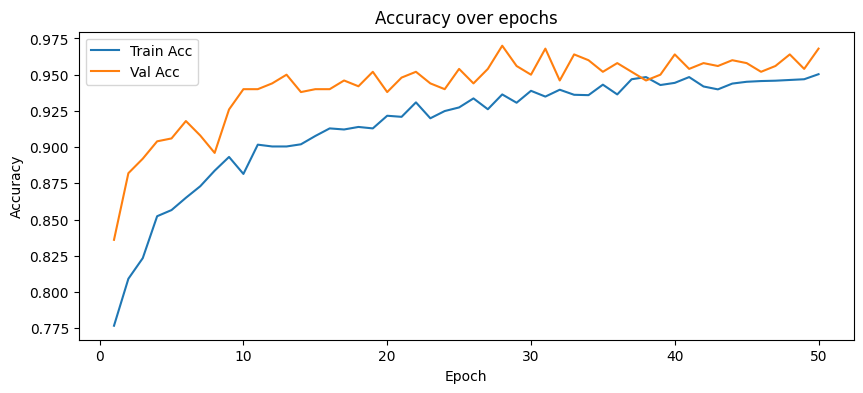

In [11]:
# ---- Plot training & validation curves ----
import matplotlib.pyplot as plt

epochs = [h[0] for h in history]
tr_loss = [h[1] for h in history]
tr_acc  = [h[2] for h in history]
val_loss= [h[3] for h in history]
val_acc = [h[4] for h in history]

plt.figure(figsize=(10,4))
plt.plot(epochs, tr_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over epochs'); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, tr_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over epochs'); plt.legend(); plt.show()

In [34]:

# Test performance + save model to same folder
test_loss, test_acc = evaluate(net, test_loader, criterion)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

model_path = 'alexnet_flowers.pth'
torch.save(net.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Test loss: 0.1265 | Test acc: 0.962
Model saved to: alexnet_flowers.pth


## 7) Evaluation Metrics — Confusion Matrix, Precision, Recall, F1
After testing, let's compute a **confusion matrix** and the **precision/recall/F1** for each class and overall.

Overall Accuracy: 0.962

Classification Report (per class + averages):
              precision    recall  f1-score   support

       Lilly      0.914     0.960     0.937       100
       Lotus      0.970     0.970     0.970       100
      Orchid      0.950     0.960     0.955       100
   Sunflower      0.990     0.990     0.990       100
       Tulip      0.989     0.930     0.959       100

    accuracy                          0.962       500
   macro avg      0.963     0.962     0.962       500
weighted avg      0.963     0.962     0.962       500

Confusion Matrix (counts):
 [[96  2  2  0  0]
 [ 1 97  1  0  1]
 [ 2  1 96  1  0]
 [ 1  0  0 99  0]
 [ 5  0  2  0 93]]


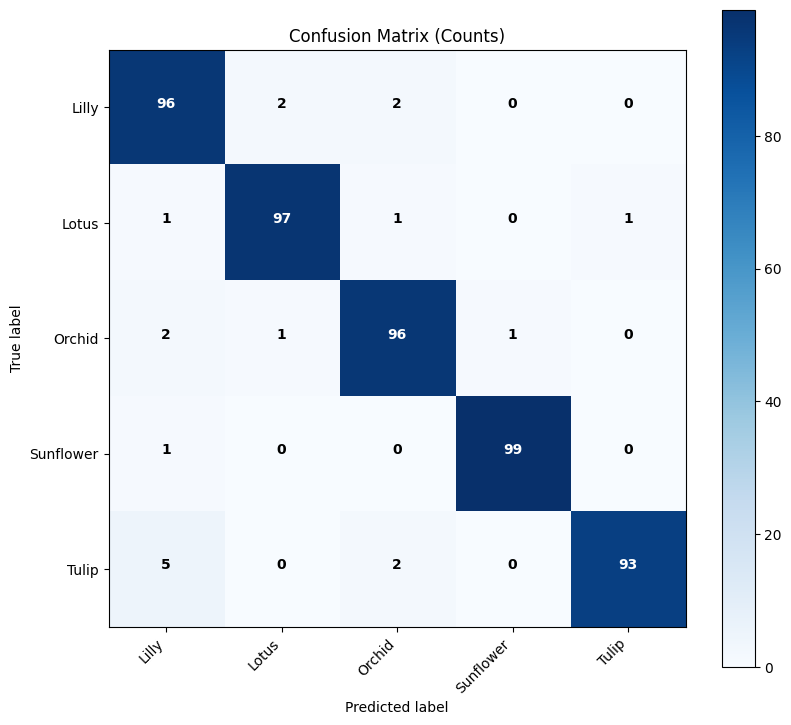

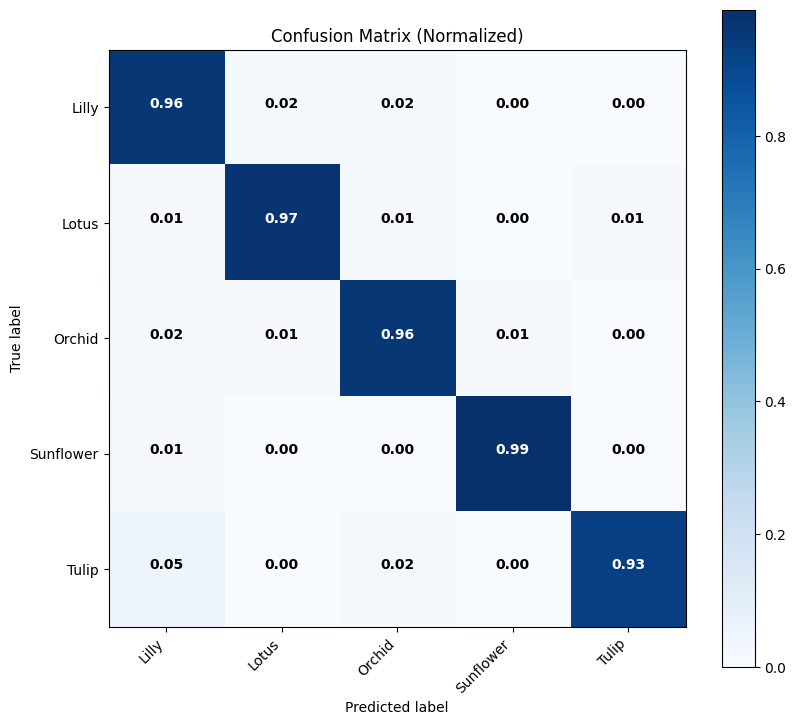

In [37]:
# Compute predictions across the entire test set for detailed metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
import itertools

@torch.no_grad()
def collect_preds(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)

y_pred, y_true = collect_preds(net, test_loader, device)
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.3f}\n")

# Per-class precision/recall/F1
print("Classification Report (per class + averages):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Confusion Matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
print("Confusion Matrix (counts):\n", cm)

# Plot Confusion Matrix with brighter colormap
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.viridis):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(0.9*len(classes)+4, 0.9*len(classes)+3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. if cm.max() > 0 else 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j]
        plt.text(j, i, format(val, fmt),
                 horizontalalignment="center",
                 color="white" if val > thresh else "black",
                 fontsize=10, fontweight='bold')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Show raw counts
plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix (Counts)', cmap=plt.cm.Blues)

# Show row-normalized percentages
plot_confusion_matrix(cm, class_names, normalize=True, title='Confusion Matrix (Normalized)', cmap=plt.cm.Blues)

## 8) Visualize predictions

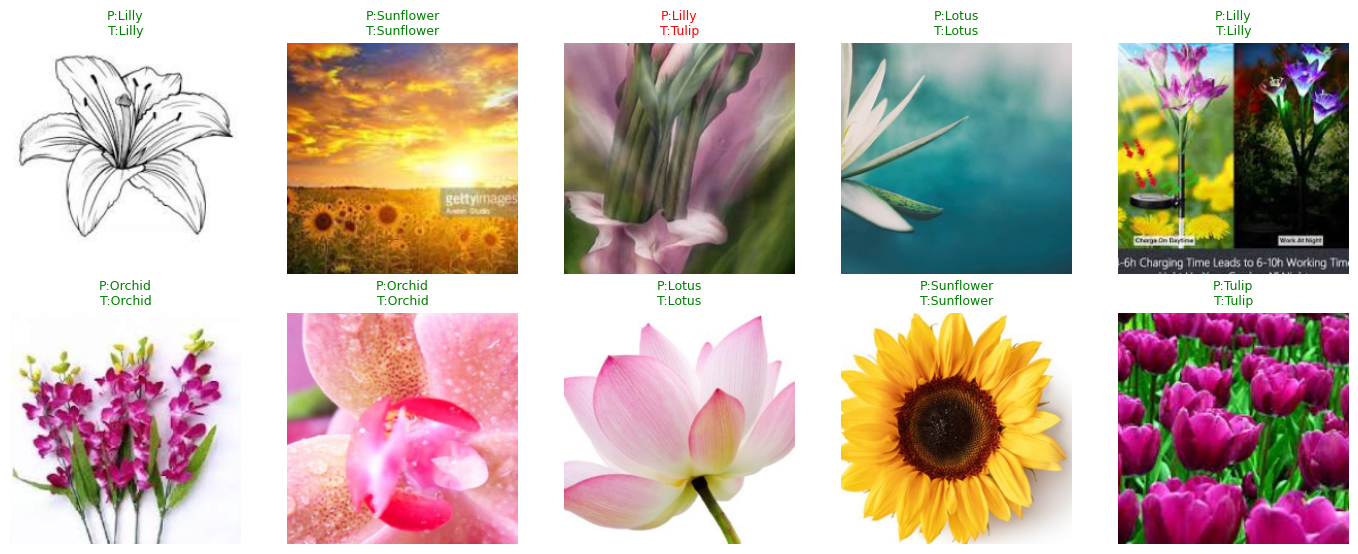

In [33]:

# ---- Visualize a few predictions ----
import math, random
def denormalize(img_tensor, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    if isinstance(mean, tuple): mean = torch.tensor(mean, device=img_tensor.device).view(3,1,1)
    if isinstance(std, tuple):  std  = torch.tensor(std,  device=img_tensor.device).view(3,1,1)
    return (img_tensor * std + mean).clamp(0,1)

@torch.no_grad()
def show_predictions_balanced(model, dataset, class_names, k_per_class=2, max_total=12):
    model.eval()
    targets = dataset.targets if hasattr(dataset, "targets") else [y for _, y in dataset]
    per_class = {c: [] for c in range(len(class_names))}
    for idx, y in enumerate(targets):
        per_class[int(y)].append(idx)

    chosen = []
    for c in range(len(class_names)):
        pool = per_class[c]
        if pool:
            k = min(k_per_class, len(pool))
            chosen += random.sample(pool, k)
    random.shuffle(chosen)
    chosen = chosen[:max_total]

    imgs, labels = [], []
    for i in chosen:
        img, y = dataset[i]
        imgs.append(img); labels.append(y)
    if not imgs:
        print("No images sampled. Check dataset path.");
    else:
        batch = torch.stack(imgs).to(device)
        labels = torch.tensor(labels, device=device)
        preds = model(batch).argmax(1)

        n = len(imgs); cols = min(5, n); rows = math.ceil(n/cols)
        plt.figure(figsize=(2.8*cols, 2.8*rows))
        for i in range(n):
            plt.subplot(rows, cols, i+1)
            disp = denormalize(batch[i].cpu()).permute(1,2,0)
            p, t = class_names[preds[i].item()], class_names[labels[i].item()]
            plt.imshow(disp); plt.axis("off")
            plt.title(f"P:{p}\nT:{t}", fontsize=9, color=("green" if p==t else "red"))
        plt.tight_layout(); plt.show()

show_predictions_balanced(net, test_ds, class_names, k_per_class=2, max_total=20)



## 9) Key takeaways

- **Convolution** = learnable pattern matcher. Many filters → many feature maps.  
- **Pooling** reduces size and keeps strongest evidence → faster & more robust.  
- **AlexNet** proved deep CNNs work at scale thanks to **ReLU**, **dropout**, **augmentation**, and **GPU training**.  
- **Transfer learning** with pretrained weights (as in our PyTorch AlexNet) is powerful when data is limited.

**Try at home**
- Freeze early layers: `for p in net.features.parameters(): p.requires_grad = False` and fine‑tune only the classifier.  
- Change optimizer (SGD vs Adam), learning rate, or number of epochs and compare validation accuracy.  
- Add more augmentation (RandomRotation, ColorJitter) and track its effect.



---

## 10) Coming next: **VGGNet** 🧱
In the next practical, we'll study **VGGNet** — a deeper CNN built almost entirely from **3×3 conv blocks**.  
We'll compare it to AlexNet and fine‑tune VGG on our flowers dataset.

> Save this notebook and get ready for **Practical 8: VGGNet**!


---

*This Practical was designed and written by **Dr. Zaid Al-Huda** to give you hands-on experience and a clear understanding of Convolutional Neural Networks, the historical significance of AlexNet, and practical skills in fine-tuning pretrained models for image classification.*